In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [2]:
DATASET_PATH = "./dataset/Logos/"
images = []

In [3]:
for idx, filename in enumerate(os.listdir(DATASET_PATH)):
    image = tf.keras.utils.load_img(os.path.join(DATASET_PATH, filename), target_size=(100, 100))
    image = tf.keras.utils.img_to_array(image)
    images.append(image)
    if idx == 500:
        break

In [4]:
images = np.asarray(images).astype(np.float32) / 255

In [5]:
x_train = images[:-10]
x_test = images[-10:]

In [6]:
BATCH_SIZE = 32

IMAGE_ORIGINAL_SIZE = x_train[0].shape
IMAGE_SHAPE = IMAGE_ORIGINAL_SIZE[0] * IMAGE_ORIGINAL_SIZE[1] * IMAGE_ORIGINAL_SIZE[2]

HIDDEN_DIM = 512
LATENT_DIM = 32

EPOCHS = 10
LEARNING_RATE = 0.0001

In [7]:
class VAE(tf.keras.Model):
    def __init__(self, dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        h_dim = dim[0]
        z_dim = dim[1]
        
        self.fc1 = tf.keras.layers.Dense(h_dim, activation=tf.nn.relu)
        self.fc2 = tf.keras.layers.Dense(z_dim)
        self.fc3 = tf.keras.layers.Dense(z_dim)
        
        self.fc4 = tf.keras.layers.Dense(h_dim)
        self.fc5 = tf.keras.layers.Dense(IMAGE_SHAPE)
        
        self.encoder_batch_norm = tf.keras.layers.BatchNormalization()
        self.decoder_batch_norm = tf.keras.layers.BatchNormalization()
        
    def encode(self, input):
        x = self.decoder_batch_norm(input)
        h = self.fc1(x)
        return self.fc2(h), self.fc3(h)
    
    def decode_logits(self, x):
        h = self.fc4(x)
        h = self.fc5(h)
        return self.decoder_batch_norm(h)
    
    def decode(self, x):
        return tf.nn.sigmoid(self.decode_logits(x))
    
    def reparameterize(self, mu, sigma):
        std = tf.exp(sigma * 0.5)
        eps = tf.random.normal(std.shape)
        return mu + eps * std
    
    def call(self, input):
        mu, sigma = self.encode(input)
        z = self.reparameterize(mu, sigma)
        x_recon_logits = self.decode_logits(z)
        
        return x_recon_logits, mu, sigma

In [8]:
model = VAE([HIDDEN_DIM, LATENT_DIM])
model.build(input_shape=(BATCH_SIZE, IMAGE_SHAPE))
model.summary()

d:\Apps\Conda\envs\TensorFlow\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'vae', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(BATCH_SIZE * 5).batch(BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [10]:
loss_hist = []
kl_div_hist = []

for i in range(EPOCHS):
    for x in dataset:
        x = tf.reshape(x, [-1, IMAGE_SHAPE])
        with tf.GradientTape() as tape:
            x_recon_logits, mu, sigma = model(x)
            
            recon_loss = tf.nn.sigmoid_cross_entropy_with_logits(x, x_recon_logits)
            recon_loss = tf.reduce_sum(recon_loss) / BATCH_SIZE
            
            kl_div = -0.5 * tf.reduce_sum(1. + sigma - tf.square(mu) - tf.exp(sigma), axis=1)
            kl_div = tf.reduce_mean(kl_div)
            
            loss = tf.reduce_mean(kl_div + recon_loss)
            
        gradient = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradient, model.trainable_variables))
        
        loss_hist.append(loss)
        kl_div_hist.append(kl_div)
    print(f"Epoch [{i + 1} / {EPOCHS}]: Recon Loss {recon_loss} | kl div {kl_div} | loss {loss}")

Epoch [1 / 10]: Recon Loss 4798.1953125 | kl div 524.3577880859375 | loss 5322.55322265625
Epoch [2 / 10]: Recon Loss 4436.84912109375 | kl div 1023.74658203125 | loss 5460.595703125
Epoch [3 / 10]: Recon Loss 3890.16650390625 | kl div 639.4628295898438 | loss 4529.62939453125
Epoch [4 / 10]: Recon Loss 2643.669189453125 | kl div 944.6845703125 | loss 3588.353759765625
Epoch [5 / 10]: Recon Loss 2374.358154296875 | kl div 387.5780334472656 | loss 2761.936279296875
Epoch [6 / 10]: Recon Loss 1793.0068359375 | kl div 356.2514343261719 | loss 2149.25830078125
Epoch [7 / 10]: Recon Loss 2578.7861328125 | kl div 286.0586853027344 | loss 2864.8447265625
Epoch [8 / 10]: Recon Loss 926.8836059570312 | kl div 340.63079833984375 | loss 1267.514404296875
Epoch [9 / 10]: Recon Loss 2209.322509765625 | kl div 300.7451171875 | loss 2510.067626953125
Epoch [10 / 10]: Recon Loss 2059.144287109375 | kl div 308.71661376953125 | loss 2367.86083984375


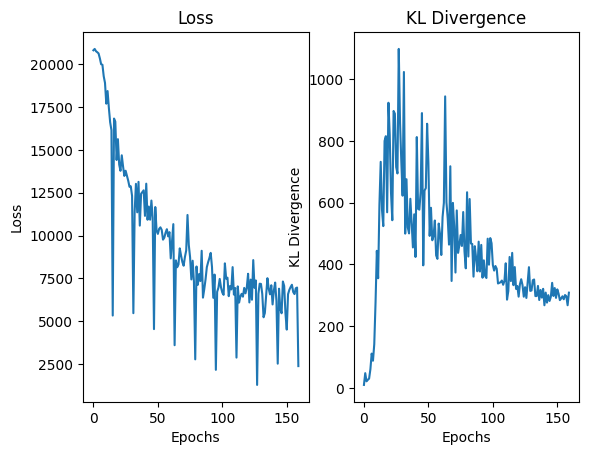

In [11]:
plt.subplot(1, 2, 1)
plt.plot(loss_hist)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(kl_div_hist)
plt.title("KL Divergence")
plt.xlabel("Epochs")
plt.ylabel("KL Divergence")

plt.show()

In [12]:
def get_img(z):
    out = model.decode(z)
    out = tf.reshape(out, (-1, IMAGE_ORIGINAL_SIZE[0], IMAGE_ORIGINAL_SIZE[1], IMAGE_ORIGINAL_SIZE[2]))
    return out

In [13]:
mu, sigma = model.encode(x_test.reshape(-1, IMAGE_SHAPE))
z = model.reparameterize(mu, sigma)
out = get_img(z)

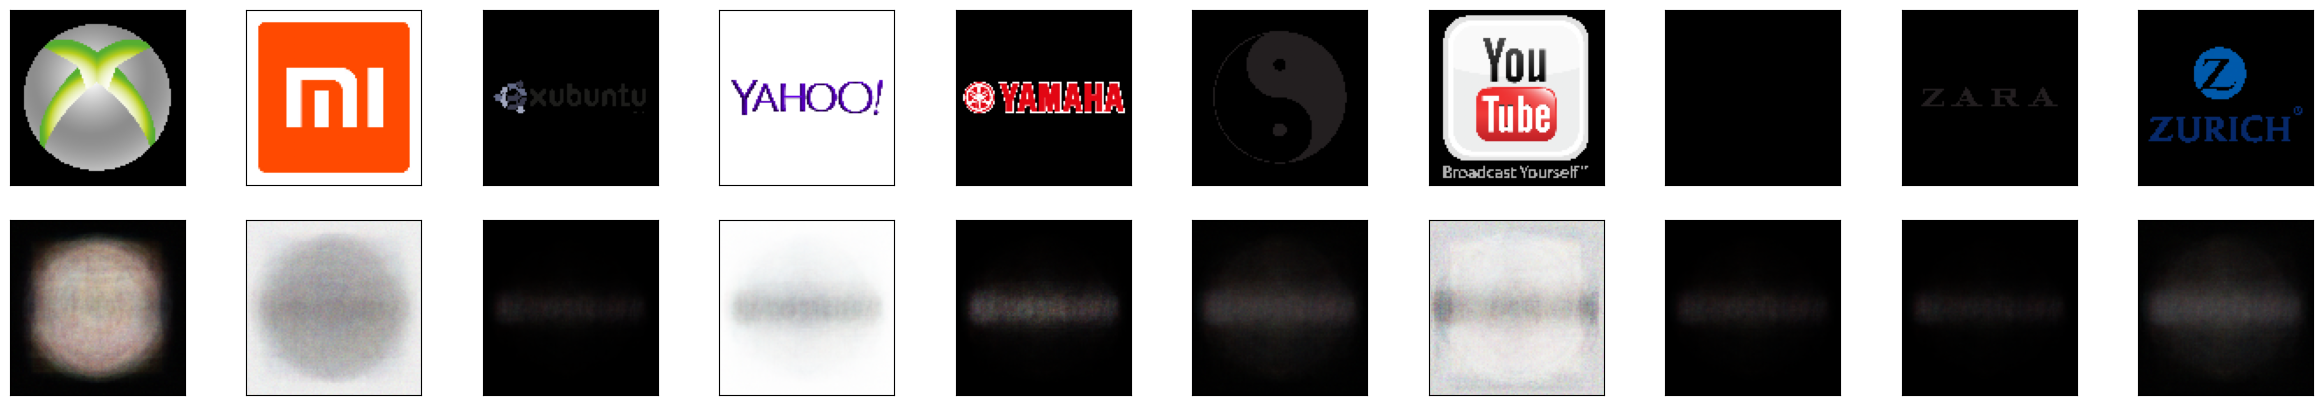

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=len(x_test), figsize = (30, 5))
for i in range(len(x_test)):
    ax[0, i].imshow(x_test[i])
    ax[0, i].get_xaxis().set_visible(False)
    ax[0, i].get_yaxis().set_visible(False)
    
    ax[1, i].imshow(out[i])
    ax[1, i].get_xaxis().set_visible(False)
    ax[1, i].get_yaxis().set_visible(False)
    
plt.show()